<a href="https://colab.research.google.com/github/imanhamid/selectionscan_NN/blob/master/objectlocalization_one_strong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade
!pip install icevision[all]

In [2]:
from icevision.all import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np

In [5]:
path = Path(base_dir + 'data/segmentation/one-strong/')

In [6]:
path_lbl = path/'labels'
path_img = path/'images'
fnames = get_image_files(path_img)

In [7]:
pos = [int(re.search("pos-(.*)_seed", str(i)).group(1)) for i in fnames]

In [8]:
bbox_xmin = [math.ceil((i / 25e6) * 200) - 5 for i in pos]

In [9]:
labl_bbox = [[i, 0, i + 11, 200] for i in bbox_xmin]

In [10]:
image_id = [re.search("/images/(.*.png)", str(i)).group(1) for i in fnames]

In [11]:
df = pd.DataFrame(list(zip(image_id, [200] * len(image_id), [200] * len(image_id), labl_bbox, [str(path_img) for i in image_id])), 
               columns =['image_id', 'width', 'height', 'bbox', 'source']) 

In [12]:
class VariantParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [13]:
VariantParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [14]:
class VariantParser(parsers.FasterRCNN, parsers.FilepathMixin, parsers.SizeMixin):
    def __init__(self, df, source):
        self.df = df
        self.source = source

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> Hashable:
        return o.image_id

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}"

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))

    def labels(self, o) -> List[int]:
        return [1]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xyxy(*np.fromiter(o.bbox, dtype="int"))]

In [15]:
class_map = ClassMap(['selected_variant'])

In [ ]:
parser = VariantParser(df, path_img)
train_rs, valid_rs = parser.parse()

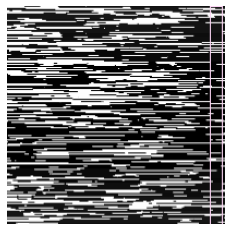

In [17]:
show_record(train_rs[30], display_label=False)

In [18]:
train_ds = Dataset(train_rs)
valid_ds = Dataset(valid_rs)

In [19]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [72]:
class_map = ClassMap(['selected_variant'])

In [268]:
# Backbone
backbone = faster_rcnn.backbones.resnet_fpn.resnet18(pretrained=True)
# Model
model = faster_rcnn.model(backbone=backbone, num_classes=len(class_map))

In [269]:
def center_metric(sample, pred):
  bbox_pred = pred['bboxes']
  if len(bbox_pred)>0:
    bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
    bbox_sample = sample['bboxes'][0]
    bbox_xaxis_sample = bbox_sample.xyxy[0:3:2]
    sample_midpoint = math.ceil((bbox_xaxis_sample[0] + bbox_xaxis_sample[1])/2)
    center_in_bbox = [i[1] >= sample_midpoint >= i[0] for i in bbox_xaxis_pred]
    center_accuracy_mean = np.mean(center_in_bbox)
  else:
    center_accuracy_mean = 0
  return center_accuracy_mean

def width_metric(pred):
  bbox_pred = pred['bboxes']
  if len(bbox_pred)>0:
    bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
    pred_width = [i[1] - i[0] for i in bbox_xaxis_pred]
    pred_width_mean = np.mean(pred_width)
  else:
    pred_width_mean = None
  return pred_width_mean
  

def num_bboxes(pred):
  num_boxes = len(pred['bboxes'])
  return num_boxes
  

In [270]:
class Center_Proportion(Metric):
    def __init__(self):
        self._props = []

    def _reset(self):
        self._props.clear()

    def accumulate(self, records, preds):
        center_results = [center_metric(sample, pred) for sample, pred in zip(records,preds)]
        self._props.extend(center_results)

    def finalize(self) -> Dict[str, float]:
        final_prop = np.mean(self._props)
        self._reset()
        return {'Center_in_Bbox': final_prop}

class Avg_Width(Metric):
    def __init__(self):
        self._widths = []

    def _reset(self):
        self._widths.clear()

    def accumulate(self, records, preds):
        width_results = [width_metric(pred) for pred in preds]
        for i in width_results:
          if i:
            self._widths.append(i)
          else:
            pass

    def finalize(self) -> Dict[str, float]:
        if self._widths:
          final_avg = np.mean(self._widths)
        else:
          final_avg = None
        self._reset()
        return {'Width_Bbox': final_avg}

class Num_Bboxes(Metric):
    def __init__(self):
        self._num = []

    def _reset(self):
        self._num.clear()

    def accumulate(self, records, preds):
        num_boxes_results = [num_bboxes(pred) for pred in preds]
        self._num.extend(num_boxes_results)

    def finalize(self) -> Dict[str, float]:
        final_num = np.mean(self._num)
        self._reset()
        return {'Num_Bbox': final_num}

In [271]:
metrics = [COCOMetric(), Num_Bboxes(), Center_Proportion(), Avg_Width()]
learn = faster_rcnn.fastai.learner(
    dls=[train_dl, valid_dl], model=model, metrics=metrics
)

In [273]:
learn.fine_tune(10, 1e-3, freeze_epochs=1, wd=0.2)

epoch,train_loss,valid_loss,COCOMetric,Num_Bboxes,Center_Proportion,Avg_Width,time
0,0.765928,0.996651,0.128861,21.960000,0.329075,12.936609,00:25


epoch,train_loss,valid_loss,COCOMetric,Num_Bboxes,Center_Proportion,Avg_Width,time
0,0.406959,0.346269,0.085841,21.270000,0.354960,12.395237,00:37
1,0.332374,0.268820,0.111611,17.720000,0.386584,12.587983,00:36
2,0.273048,0.218309,0.272607,9.445000,0.477625,17.575998,00:36
3,0.222816,0.185391,0.345733,6.170000,0.614228,16.375093,00:36
4,0.186585,0.164755,0.380269,4.620000,0.693069,16.672956,00:36
5,0.159720,0.155098,0.361303,3.660000,0.731935,15.521113,00:36
6,0.144191,0.140506,0.386656,6.780000,0.560681,13.41654,00:36
7,0.132188,0.137065,0.386081,4.115000,0.712210,14.143903,00:36
8,0.124978,0.130861,0.402742,4.420000,0.690091,14.009785,00:36
9,0.121854,0.131210,0.401436,4.610000,0.683782,14.020866,00:36


In [274]:
infer_dl = faster_rcnn.infer_dl(valid_ds, batch_size=16)

In [275]:
samples, preds = faster_rcnn.predict_dl(model, infer_dl)

  0%|          | 0/13 [00:00<?, ?it/s]

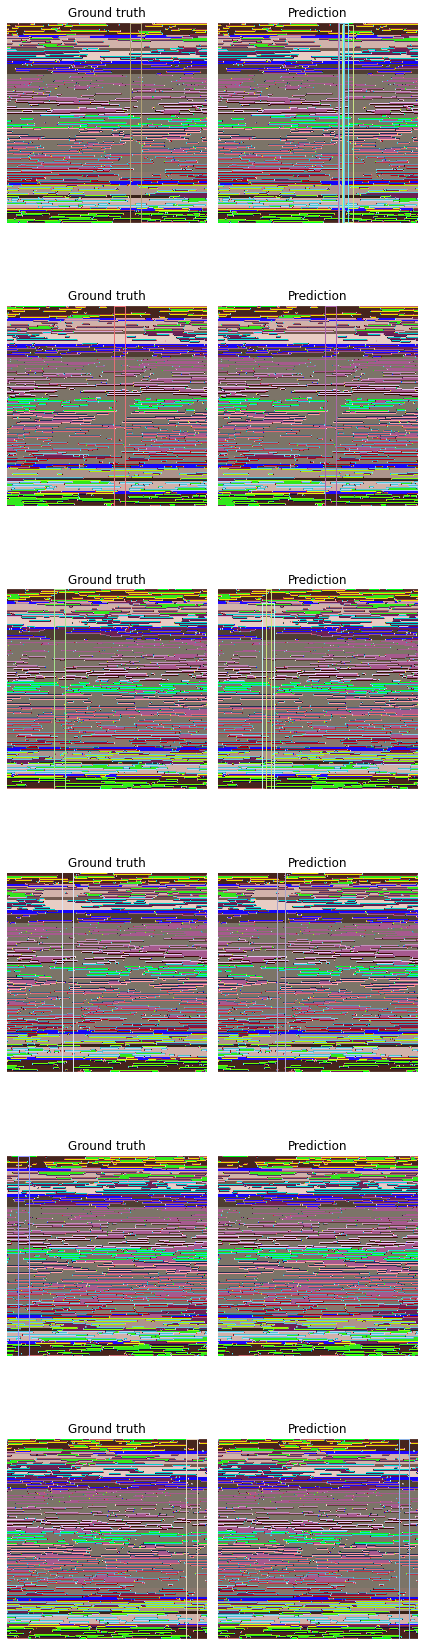

In [276]:
show_preds(samples[:6], preds[:6], class_map, display_label=False, display_mask=False)

In [277]:
center_results = [center_metric(sample, pred) for sample, pred in zip(samples,preds)]

In [278]:
np.mean(center_results)

0.8519999999999999

In [279]:
num_boxes_results = [num_bboxes(pred) for pred in preds]

In [280]:
np.mean(num_boxes_results)

1.5

In [281]:
width_results = [width_metric(pred) for pred in preds]

In [282]:
final_widths = []
for i in width_results:
    if i:
      final_widths.append(i)
    else:
      pass
np.mean(final_widths)

11.205215

In [283]:
infer_dl = faster_rcnn.infer_dl(valid_ds, batch_size=16)

In [284]:
samples, preds = faster_rcnn.predict_dl(model, infer_dl)

  0%|          | 0/13 [00:00<?, ?it/s]

In [247]:
center_results = [center_metric(sample, pred) for sample, pred in zip(samples2,preds2)]

In [248]:
sum(center_results)/len(center_results)

0.0

In [239]:
metrics = [COCOMetric()]

In [241]:
learn2 = faster_rcnn.fastai.learner(
    dls=[train_dl, valid_dl], model=model, metrics=metrics
)
learn2.fine_tune(10, 1e-2, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.168409,0.337048,0.054180,00:23


epoch,train_loss,valid_loss,COCOMetric,time
0,0.199290,0.194750,0.089022,00:34
1,0.208476,0.320243,0.046750,00:33
2,0.211351,0.186933,0.085446,00:35
3,0.219486,0.170061,0.068556,00:34
4,0.176519,0.155301,0.071944,00:33
5,0.149823,0.153429,0.160330,00:33
6,0.129602,0.144188,0.181354,00:33
7,0.119788,0.121309,0.147005,00:33
8,0.109946,0.131003,0.182571,00:33
9,0.105872,0.129177,0.172267,00:33


In [81]:
imgs = [sample["img"] for sample in samples]
show_preds(
    samples=imgs[:6],
    preds=preds[:6],
    class_map=class_map,
    ncols=3,
)

#LOOK FOR A DIV=TRUE? FOR B/W IMAGES
#does it matter we have preds>true bboxes?
#new accuracy metric, since we only care about one axis???

TypeError: ignored

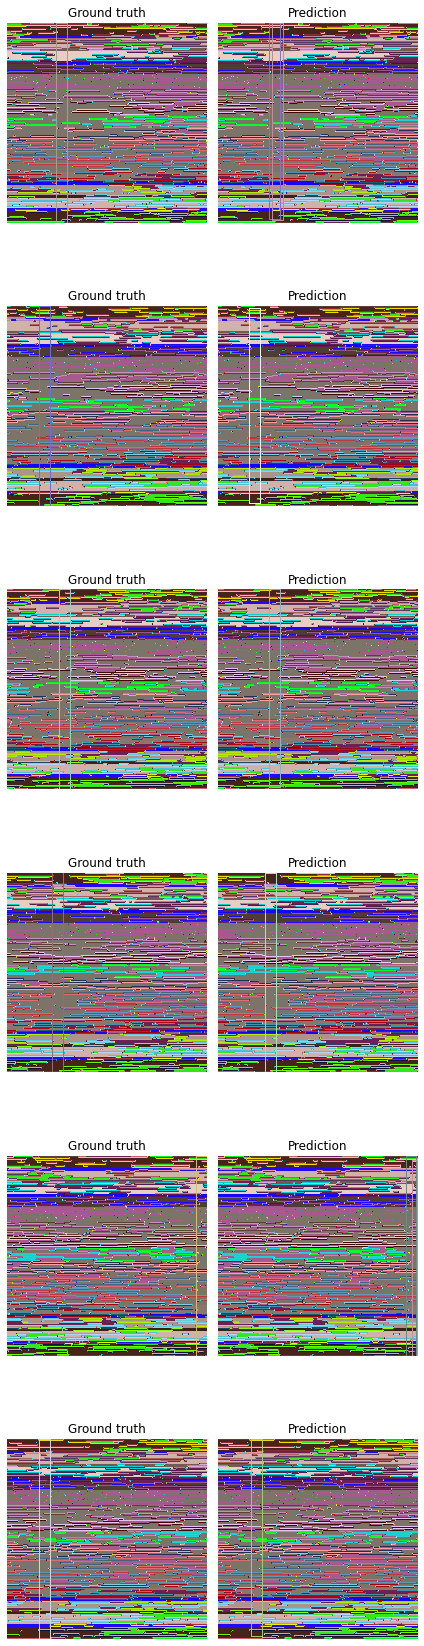

In [82]:
show_preds(samples[:6], preds[:6], class_map, display_label=False, display_mask=False)

In [129]:
bbox_xaxis_pred = preds[1]['bboxes'][0].xyxy[0:3:2]

In [140]:
bbox_xaxis_pred = [i.xyxy[0:3:2] for i in preds[0]['bboxes']]

In [153]:
center_in_bbox = [i[1] >= sample_midpoint >= i[0] for i in bbox_xaxis_pred]

In [144]:
bbox_xaxis_sample = samples[0]['bboxes'][0].xyxy[0:3:2]

In [154]:
sum(center_in_bbox)/len(center_in_bbox)

1.0

In [146]:
sample_midpoint = math.ceil((bbox_xaxis_sample[1] + bbox_xaxis_sample[0])/2)

In [128]:
 bbox_xaxis_pred[1] >= sample_midpoint >= bbox_xaxis_pred[0]

True

In [164]:
def center_metric(pred, sample):
  bbox_pred = pred['bboxes']
  bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
  bbox_sample = sample['bboxes'][0]
  bbox_xaxis_sample = bbox_sample.xyxy[0:3:2]
  sample_midpoint = math.ceil((bbox_xaxis_sample[0] + bbox_xaxis_sample[1])/2)
  center_in_bbox = [i[1] >= sample_midpoint >= i[0] for i in bbox_xaxis_pred]
  center_accuracy_mean = sum(center_in_bbox)/len(center_in_bbox)
  return center_accuracy_mean

In [171]:
center_results = [center_metric(pred, sample) for pred, sample in zip(preds,samples)]

In [173]:
sum(center_results) / len(center_results)

0.9149999999999998

In [178]:
def width_metric(pred, sample):
  bbox_pred = pred['bboxes']
  bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
  pred_width = [i[1] - i[0] for i in bbox_xaxis_pred]
  pred_width_mean = sum(pred_width)/len(pred_width)
  return pred_width_mean

In [180]:
width_results = [width_metric(pred, sample) for pred, sample in zip(preds,samples)]

In [182]:
sum(width_results) / len(width_results)

11.395175630251567

In [224]:
if len([]):
  print("yes")

In [9]:
from icedata import *

In [10]:
data_dir = icedata.pets.load()

/usr/local/lib/python3.6/dist-packages/icedata/datasets/pets/data.py:75: UserWarning: load will be deprecated in 0.1.0, please use load_data instead
  warnings.warn("load will be deprecated in 0.1.0, please use load_data instead")


  0%|          | 0/791918971 [00:00<?, ?B/s]

  0%|          | 0/19173078 [00:00<?, ?B/s]

In [35]:
data_dir

Path('/root/.icevision/data/pets')

In [32]:
!less /root/.icevision/data/pets/annotations/xmls/Abyssinian_1.xml

<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source> <database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><imag e>flickr</image></source><size><width>600</width><height>400</height><depth>3</d epth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose> <truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object>< /annotation>
(END)^C


In [12]:
class_map = icedata.pets.class_map()
parsers.VocXmlParser

In [15]:
parser = icedata.pets.parser(data_dir, class_map)

In [17]:
train_records, valid_records = parser.parse()

  0%|          | 0/3686 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126


In [ ]:


def labels(self, o) -> List[int]:
        name = re.findall(r"^(.*)_\d+$", o.stem)[0]
        class_id = self.class_map.get_name(name)

        # there is an image with two cats (same breed)
        num_objs = len(self._root.findall("object"))

        return [class_id] * num_objs

In [41]:
[RecordBaseRecordImageidRecordMixinFilepathRecordMixinSizeRecordMixinLabelsRecordMixinBBoxesRecordMixinRecordMixinMutableMappingMappingCollectionSizedIterableContainerobject with 6 items, RecordBaseRecordImageidRecordMixinFilepathRecordMixinSizeRecordMixinLabelsRecordMixinBBoxesRecordMixinRecordMixinMutableMappingMappingCollectionSizedIterableContainerobject with 6 items, RecordBaseRecordImageidRecordMixinFilepathRecordMixinSizeRecordMixinLabelsRecordMixinBBoxesRecordMixinRecordMixinMutableMappingMappingCollectionSizedIterableContainerobject with 6 items, RecordBaseRecordImageidRecordMixinFilepathRecordMixinSizeRecordMixinLabelsRecordMixinBBoxesRecordMixinRecordMixinMutableMappingMappingCollectionSizedIterableContainerobject with 6 items, RecordBaseRecordImageidRecordMixinFilepathRecordMixinSizeRecordMixinLabelsRecordMixinBBoxesRecordMixinRecordMixinMutableMappingMappingCollectionSizedIterableContainerobject with 6 items, ...] (2948 items total)

TypeError: ignored

In [24]:
train_records[20]

Record:
	- Image ID: 1358
	- Filepath: /root/.icevision/data/pets/images/american_pit_bull_terrier_163.jpg
	- Image size (width, height): (300, 225)
	- Labels: [14]
	- BBoxes: [<BBox (xmin:5, ymin:38, xmax:131, ymax:159)>]

In [14]:
ClassMap(['selected_variant'])

<ClassMap: {'background': 0, 'selected_variant': 1}>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

In [3]:
from fastai.vision.all import *

In [4]:
import fastai; fastai.__version__

'2.2.5'

Mounted at /content/gdrive


In [12]:
img2bbox = dict(zip(image_names, labl_bbox))

In [13]:
 dbs = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]],
                 n_inp=1)

In [14]:
dls = dbs.dataloaders(path_img, path=path, bs=8)

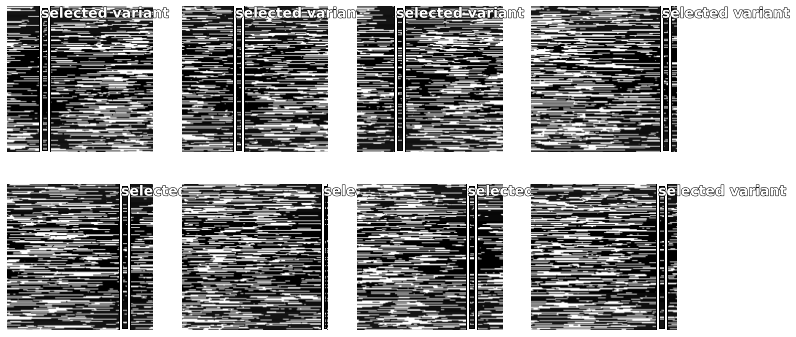

In [15]:
dls.show_batch(max_n=9)

In [16]:
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
%cd "Practical-Deep-Learning-for-Coders-2.0/Computer Vision"

Cloning into 'Practical-Deep-Learning-for-Coders-2.0'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1292 (delta 18), reused 27 (delta 6), pack-reused 1227
Receiving objects: 100% (1292/1292), 86.33 MiB | 31.86 MiB/s, done.
Resolving deltas: 100% (805/805), done.
/content/Practical-Deep-Learning-for-Coders-2.0/Computer Vision


In [17]:
from imports import *

In [19]:
encoder = create_body(resnet18, pretrained=False)

In [20]:
get_c(dls)

4

In [21]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [22]:

create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [23]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [24]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [25]:
arch.box_regressor


Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [26]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [27]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)


In [28]:

def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [29]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [30]:
learn.freeze()

In [31]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,0.008172,0.000435,02:50
1,0.001191,0.000201,00:26
2,0.000278,0.000115,00:25
3,0.000104,0.000059,00:25
4,0.000046,0.000028,00:25
5,0.000022,0.000015,00:25
6,0.000013,0.000010,00:25
7,0.000009,0.000008,00:25
8,0.000008,0.000008,00:25
9,0.000007,0.000007,00:25


TypeError: ignored

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=L1LossFlat)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


TypeError: ignored

In [ ]:
learn.fine_tune(20, base_lr=3e-5, freeze_epochs=10,pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,time


RuntimeError: ignored

In [ ]:
torch.set_printoptions(profile="full")
print(mask.getcolors())

[(39800, 0), (200, 255)]


In [ ]:
codes = np.array(['neutral', 'sweep'], dtype=str)

In [ ]:
def MaskBlock(codes=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), 
                          batch_tfms=IntToFloatTensor(div_mask=255))

In [ ]:
dbs = DataBlock(blocks=(ImageBlock, MaskBlock(codes,)),
                   get_items = get_image_files,
                   get_y = get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

In [ ]:
dls = dbs.dataloaders(path_img, path=path, bs=8)

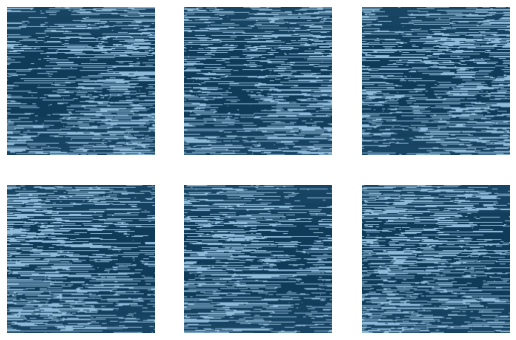

In [ ]:
dls.show_batch(max_n=6)

In [ ]:
from sklearn.metrics import auc

def mean_auc(pred, targ, axis = 1):
  targ = targ.squeeze(1)
  pred = pred.argmax(dim=axis)
  targs = torch.where(torch.sigmoid(targ.sum(dim=1).float())>0.5, torch.sigmoid(targ.sum(dim=1).float()), tensor(0.).cuda())
  preds = torch.where(torch.sigmoid(pred.sum(dim=1).float())>0.5, torch.sigmoid(pred.sum(dim=1).float()), tensor(0.).cuda())

  
  positions = torch.arange(0, 200).cuda()
  positions = positions.view(1, 200, 1).cuda()
  distances = torch.transpose(torch.sub(torch.where(targs==1.)[1], positions).abs().squeeze(), 0, 1)

  window_means = torch.Tensor([[preds[y][torch.where(distances[y]<= i)].mean() for i in range(100)] for y in range(len(preds))]).mean(0)
  
  batch_auc = auc(torch.arange(0, 100), window_means)

  return batch_auc

In [ ]:
def mean_pos0(pred, targ, axis = 1):
  targ = targ.squeeze(1)
  pred = pred.argmax(dim=axis)
  targs = torch.where(torch.sigmoid(targ.sum(dim=1).float())>0.5, torch.sigmoid(targ.sum(dim=1).float()), tensor(0.).cuda())
  preds = torch.where(torch.sigmoid(pred.sum(dim=1).float())>0.5, torch.sigmoid(pred.sum(dim=1).float()), tensor(0.).cuda())

  
  positions = torch.arange(0, 200).cuda()
  positions = positions.view(1, 200, 1).cuda()
  distances = torch.transpose(torch.sub(torch.where(targs==1.)[1], positions).abs().squeeze(), 0, 1)

  window_means = torch.Tensor([[preds[y][torch.where(distances[y]<= i)].mean() for i in range(100)] for y in range(len(preds))]).mean(0)

  return window_means[0]

def mean_pos10(pred, targ, axis = 1):
  targ = targ.squeeze(1)
  pred = pred.argmax(dim=axis)
  targs = torch.where(torch.sigmoid(targ.sum(dim=1).float())>0.5, torch.sigmoid(targ.sum(dim=1).float()), tensor(0.).cuda())
  preds = torch.where(torch.sigmoid(pred.sum(dim=1).float())>0.5, torch.sigmoid(pred.sum(dim=1).float()), tensor(0.).cuda())

  
  positions = torch.arange(0, 200).cuda()
  positions = positions.view(1, 200, 1).cuda()
  distances = torch.transpose(torch.sub(torch.where(targs==1.)[1], positions).abs().squeeze(), 0, 1)

  window_means = torch.Tensor([[preds[y][torch.where(distances[y]<= i)].mean() for i in range(100)] for y in range(len(preds))]).mean(0)

  return window_means[10]

In [ ]:
learn = unet_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(axis=1, 
                    weight=torch.tensor([0.5,1.]).cuda()), metrics=[mean_auc, mean_pos0, mean_pos10])

In [ ]:
learn.fine_tune(20, base_lr=3e-5, freeze_epochs=10,pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.237318,0.105883,61.337972,0.664503,0.672783,00:31
1,0.100722,0.074085,2.976785,0.042454,0.040287,00:30
2,0.063813,0.053296,0.117352,0.000000,0.000661,00:30
3,0.048708,0.044777,0.014536,0.000000,0.000244,00:31
4,0.042549,0.041231,0.000000,0.000000,0.000000,00:30
5,0.039144,0.038540,0.000000,0.000000,0.000000,00:30
6,0.036809,0.036981,0.000000,0.000000,0.000000,00:30
7,0.034493,0.037191,0.000000,0.000000,0.000000,00:30
8,0.032882,0.036544,0.008291,0.000000,0.000210,00:31
9,0.030847,0.039752,0.165022,0.004404,0.004045,00:30


epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.027437,0.040278,0.538348,0.038556,0.012009,00:31
1,0.026767,0.042606,1.519432,0.092890,0.034882,00:32
2,0.026203,0.044346,1.828391,0.136490,0.041641,00:32
3,0.025650,0.045585,2.281094,0.138724,0.052326,00:32
4,0.024987,0.049392,2.775052,0.163496,0.064334,00:32
5,0.024312,0.049620,3.036840,0.204969,0.068271,00:32
6,0.023918,0.049437,4.596864,0.273232,0.107117,00:32
7,0.023382,0.059151,6.574491,0.368264,0.151964,00:32
8,0.022536,0.057330,6.312740,0.386691,0.144935,00:32
9,0.021835,0.059096,7.053799,0.404476,0.165440,00:32


In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
def mean_auc_cpu(pred, targ):
  targs = torch.where(torch.sigmoid(targ.sum(dim=1).float())>0.5, torch.sigmoid(targ.sum(dim=1).float()), tensor(0.))
  preds = torch.where(torch.sigmoid(pred.sum(dim=1).float())>0.5, torch.sigmoid(pred.sum(dim=1).float()), tensor(0.))

  positions = torch.arange(0, 200)
  positions = positions.view(1, 200, 1)
  distances = torch.transpose(torch.sub(torch.where(targs==1.)[1], positions).abs().squeeze(), 0, 1)

  window_means = torch.Tensor([[preds[y][torch.where(distances[y]<= i)].mean() for i in range(100)] for y in range(len(preds))]).mean(0)
  
  return window_means

In [ ]:
window_means = mean_auc_cpu(interp.decoded, interp.targs)

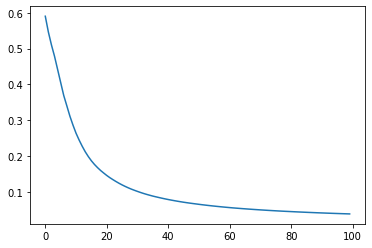

In [ ]:
matplotlib.pyplot.plot(window_means)

In [ ]:
window_means[0], window_means[10]

(tensor(0.5900), tensor(0.2639))

In [ ]:
learn.fit_one_cycle(8, lr_max=3e-5)

epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.015703,0.098464,12.002695,0.588708,0.282413,00:32
1,0.019265,0.057628,7.430831,0.358139,0.174179,00:32
2,0.021387,0.047320,9.780897,0.460721,0.223765,00:32
3,0.019084,0.053832,8.287128,0.390973,0.189367,00:32
4,0.016956,0.063926,9.457602,0.400397,0.221266,00:32
5,0.013593,0.071038,11.169602,0.524496,0.259566,00:32
6,0.010325,0.088293,9.626084,0.474787,0.222134,00:32
7,0.008742,0.096731,9.059047,0.447370,0.210155,00:31


In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
window_means = mean_auc_cpu(interp.decoded, interp.targs)

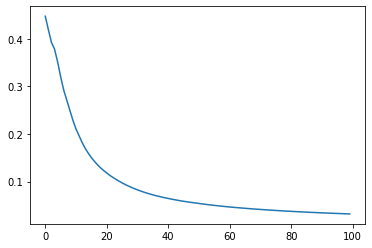

In [ ]:
matplotlib.pyplot.plot(window_means)

In [ ]:
window_means[0], window_means[10]

(tensor(0.4474), tensor(0.2102))

In [ ]:
learn.fit_one_cycle(10, wd=1e-2, lr = slice(3e-5))

epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.028317,0.034430,0.120787,0.014133,0.002696,00:32
1,0.031335,0.032921,0.242280,0.025848,0.005181,00:32
2,0.030337,0.034501,0.008453,0.000000,0.000174,00:32
3,0.028562,0.032041,0.000000,0.000000,0.000000,00:31
4,0.026540,0.033534,0.000000,0.000000,0.000000,00:32
5,0.025166,0.032677,0.000000,0.000000,0.000000,00:31
6,0.023304,0.032496,0.155014,0.022680,0.003100,00:32
7,0.019407,0.037665,7.101505,0.545173,0.155452,00:32
8,0.015862,0.050868,10.257111,0.673942,0.229500,00:32
9,0.012521,0.064211,10.107177,0.658454,0.227076,00:32


In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
window_means = mean_auc_cpu(interp.decoded, interp.targs)

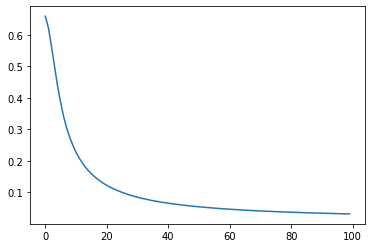

In [ ]:
matplotlib.pyplot.plot(window_means)

In [ ]:
window_means[0], window_means[10]

(tensor(0.6585), tensor(0.2271))

In [ ]:
learn.fine_tune(5, freeze_epochs=5)

epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.011890,0.065222,11.405474,0.704867,0.258543,00:31
1,0.014007,0.056037,9.540545,0.635364,0.213246,00:31
2,0.014996,0.074628,12.099638,0.723331,0.275054,00:31
3,0.016846,0.037294,12.221889,0.688803,0.275719,00:31
4,0.018703,0.043896,0.000000,0.000000,0.000000,00:31


epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.012833,0.095442,11.424605,0.664547,0.259660,00:32
1,0.013378,0.077037,11.992939,0.686969,0.273763,00:32
2,0.012578,0.093258,11.288776,0.681672,0.255244,00:32
3,0.009527,0.101172,11.580418,0.684108,0.261110,00:32
4,0.006125,0.137898,11.081012,0.664002,0.250049,00:32


In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
window_means = mean_auc_cpu(interp.decoded, interp.targs)

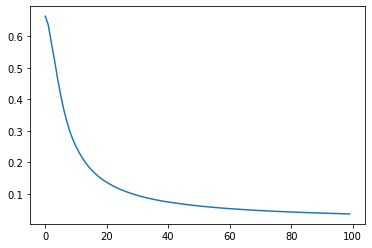

In [ ]:
matplotlib.pyplot.plot(window_means)

In [ ]:
window_means[0], window_means[10]

(tensor(0.6640), tensor(0.2500))

In [ ]:
pred_sums = []

for i in interp.decoded:
  pred_colsum = i.sum(dim=0)
  pred_sums.append(pred_colsum)

In [ ]:
target = interp.targs

In [ ]:
targ_sums = []

for i in target:
  targ_colsum = i.sum(dim=0)
  targ_sums.append(targ_colsum)

In [ ]:
import numpy as np
import pandas as pd

pred_sums_np = np.asarray([to_np(i) for i in pred_sums])
pred_sums_df = pd.DataFrame(pred_sums_np)

targ_sums_np = np.asarray([to_np(i) for i in targ_sums])
targ_sums_df = pd.DataFrame(targ_sums_np)

In [ ]:
pred_sums_df.to_csv("/content/gdrive/My Drive/fastai-v3/data/pred_sums_one-strong2.txt", sep="\t")
targ_sums_df.to_csv("/content/gdrive/My Drive/fastai-v3/data/target_sums_one-strong2.txt", sep="\t")